This workbook illustrates a simple case where unsupervised learning using K-Means clustering works well when the number of clusters is set equal to a preferred value, but not so well when iterative sub-clustering with 2 clusters is performed. An example where the performance of sub-clustering is affected by the variance in the distribution of the dataset is also shown.

Suppose we were given some 2d data, and that we were *told* that this data is very naturally grouped into 3 categories, and that our task was to find what these 3 categories were. The person who gave us this data secretly knew which one of the 3 labels each datapoint carried, but did not give us this information, and we had to devise a good unsupervising learning algorithm which could successfully replicate the labels the data-provider held in secret.

This is the situation we'll try to mimic below by creating some fake data, labelling it, then hiding those labels, performing unsupervised learning on the fake data, going only with the knowledge that we are to find 3 clusters of data, and then benchmarking the learned labels against the originally assigned ones.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

The fake data we'll generate is a bunch of 2d points sampled from a Gaussian distribution centered around each of 3 equidistant points, which we may call A, B and C. The datapoints sampled around each of these points could then be said to each belong to clusters A, B and C respectively -- these form the 'original' labels of the data points (i.e. the labels that the data-provider would've chosen to hide from us in the hypothetical situation described above).

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


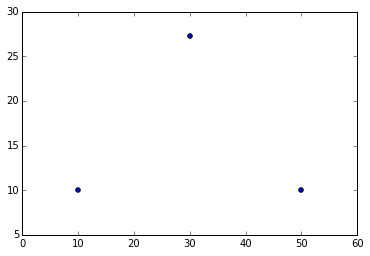

In [2]:
# Pick some equidistant points A, B and C on the xy-plane

xA, yA = 10, 10
xB, yB = 50, 10
xC, yC = 30, 10 + 0.5 * np.sqrt(3.) * 20

# They look like this
plt.figure()
plt.scatter([xA, xB, xC], [yA, yB, yC])
plt.show()

In [3]:
# Add some gaussian noise around each of these points,
# associate points drawn around a single point into a single cluster

num_points = 500
stdev = 8.0

# points drawn around 1st point: cluster 'A'
clusterA_x = [xA] + list(np.random.normal(loc=xA, scale=stdev, size=num_points-1))
clusterA_y = [yA] + list(np.random.normal(loc=yA, scale=stdev, size=num_points-1))
# points drawn around 2nd point: cluster 'B'
clusterB_x = [xB] + list(np.random.normal(loc=xB, scale=stdev, size=num_points-1))
clusterB_y = [yB] + list(np.random.normal(loc=yB, scale=stdev, size=num_points-1))
# points drawn around 3rd point: cluster 'C'
clusterC_x = [xC] + list(np.random.normal(loc=xC, scale=stdev, size=num_points-1))
clusterC_y = [yC] + list(np.random.normal(loc=yC, scale=stdev, size=num_points-1))

# gather all the datapoints
x = clusterA_x + clusterB_x + clusterC_x
y = clusterA_y + clusterB_y + clusterC_y
data = zip(x, y)

In [4]:
# Check for a very edgy edge case where a random point could be generated more than once!
if len(data) != len(set(data)):
    raise
    
# Create labels for the clusters
d_original_labels = {z: 'A' for z in data[:num_points]}
d_original_labels.update({z: 'B' for z in data[num_points: 2*num_points]})
d_original_labels.update({z: 'C' for z in data[2*num_points: 3*num_points]})

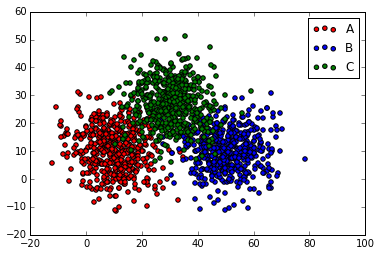

In [5]:
# Plot the clusters
plt.figure()
plt.scatter(x[:num_points], y[:num_points], label='A', c='red')
plt.scatter(x[num_points: 2*num_points], y[num_points: 2*num_points], label='B', c='blue')
plt.scatter(x[2*num_points:], y[2*num_points:], label='C', c='green')
plt.legend(loc='upper right')
plt.show()

In the above, cluster A is colored red, cluster B is blue, and cluster C is green (note: this is just for illustrative purposes; color assignment of clusters in the plots below need not be the same)

## K-Means with 3 clusters

In [6]:
kmeans3 = KMeans(n_clusters=3).fit(data)

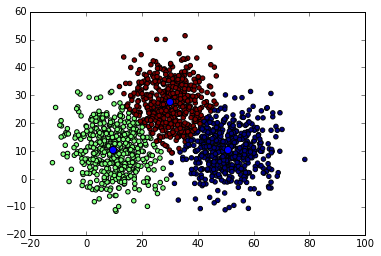

In [7]:
plt.figure()
plt.scatter(x, y, c=kmeans3.labels_)
plt.scatter(kmeans3.cluster_centers_[:, 0], kmeans3.cluster_centers_[:, 1], c='b', s=50.0)
plt.show()

The predicted clusters and their centers qualitatively look similar to our 'actual' (original) clusters. The original labelling of the datapoints with 'A', 'B' and 'C' was arbitrary. All we know is that there are 3 clusters which we want to identify, so that is what our algorithm tries to find. But we can associate the cluster on the bottom-left with cluster A, the one on the bottom-right with B, and the one on top with C, and then ask how accurately this unsupervised algorithm captures the labels we originally assigned to the datapoints.

Of course, one could complain that this association with the original labels is hand-picked, but we could make this more rigorous by, for example, demanding to choose the assignment that maximizes the accuracy score calculated below; at least visually, in this case it is clear that any other association with the original labels would only decrease this accuracy score.

In [8]:
d_label_3clusters = {'A': kmeans3.labels_[0], 'B': kmeans3.labels_[500], 'C': kmeans3.labels_[1000]}
print d_label_3clusters.items()

[('A', 1), ('C', 2), ('B', 0)]


In [9]:
original_labels = [d_label_3clusters[d_original_labels[i]] for i in data]
print set(original_labels[:500])  # should be cluster 'A'
print set(original_labels[500:1000])  # should be cluster 'B'
print set(original_labels[1000:1500])  # should be cluster 'C'

set([1])
set([0])
set([2])


In [10]:
print "Accuracy: ", \
    len([_ for i, xx in enumerate(original_labels) if xx == kmeans3.labels_[i]])/float(len(original_labels))

Accuracy:  0.932666666667


So K-Means with 3 clusters identifies the 'correct' (originally assigned) cluster of the datapoints with about 93% accuracy. Not excellent, but not bad either.

## K-Means sub-clustering with 2 clusters at a time

Next, we will perform K-means with 2 clusters once, then perform K-Means with 2 clusters again on one of the previously identified clusters. In this manner, we will again end up with 3 clusters in all, but as we'll see, the degree to which this clustering agrees with the original labeling is much less than before.

In [11]:
kmeans2 = KMeans(n_clusters=2).fit(data)

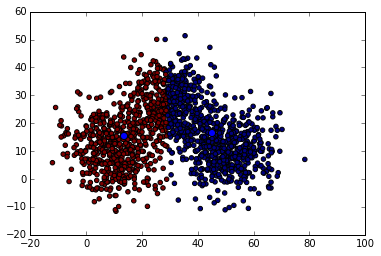

In [12]:
plt.figure()
plt.scatter(x, y, c=kmeans2.labels_)
plt.scatter(kmeans2.cluster_centers_[:, 0], kmeans2.cluster_centers_[:, 1], c='b', s=50.0)
plt.show()

The cluster centers after the first round of clustering are seen above. They divide the data into roughly equal halves, which we may call clusters D and E.

Next, we will pick one of these clusters, and perform clustering within this cluster.

#### Sub-clustering of one of the clusters

In [13]:
# First partition the 2 previously identified clusters
dataD = [x for i, x in enumerate(data) if kmeans2.labels_[i] == 0]
dataE = [x for i, x in enumerate(data) if kmeans2.labels_[i] == 1]

# Perform sub-clustering on both clusters D and E (but pick one of them below)
kmeans2_D2 = KMeans(n_clusters=2).fit(dataD)
kmeans2_E2 = KMeans(n_clusters=2).fit(dataE)

In [14]:
data_ = np.array(dataD + dataE)

We can choose to keep one of the original clusters, plus the two sub-clusters of the other one of the previously identified clusters, to get a total of 3 clusters. Their centers are plotted below.

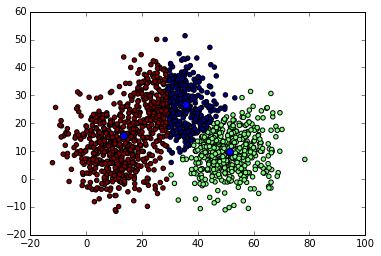

In [15]:
plt.figure()
plt.scatter(data_[:, 0], data_[:, 1], c=kmeans2_D2.labels_.tolist() + [2]*len(dataE))
plt.scatter(kmeans2_D2.cluster_centers_[:, 0], kmeans2_D2.cluster_centers_[:, 1], c='b', s=50.0)
plt.scatter(kmeans2.cluster_centers_[1, 0], kmeans2.cluster_centers_[1, 1], c='b', s=50.0)
plt.show()

This qualitatively looks different from the original cluster labels we assigned to our datapoints, which were equally distributed among the 3 clusters. In the sub-clustering approach, the cluster we chose not to sub-cluster is naturally much bigger than the other two. We can also calculate the accuracy of how well this approach learns the original labels.

Here again, we must associate the predicted 3 clusters with the original 3. A choice that would maximize the accuracy score calculated below (see the related discussion in the previous section) would be to identify cluster 'A' with the label that this particular approach of K-Means sub-clustering predicts for (xA, yA), identify cluster 'B' with the label for (xB, yB) and cluster 'C' with whatever the leftover label is.

In [16]:
# all predictions of this scheme in the order of
# (all data points from D) + (all data points from E)

preds = np.array(kmeans2_D2.predict(data_[:len(dataD)]).tolist() + \
                         (kmeans2.predict(data_[len(dataD):]) + 1).tolist())

d_tmp_labels = {}

# To our original cluster 'A', we can assign the predicted label of (xA, yA)
for i, x in enumerate(data_):
    if np.allclose(x, (xA, yA)):
        print preds[i]
        d_tmp_labels['A'] = preds[i]
        break
        
# To our original cluster 'B', we can assign the predicted label of (xB, yB)
for i, x in enumerate(data_):
    if np.allclose(x, (xB, yB)):
        print preds[i]
        d_tmp_labels['B'] = preds[i]
        break
        
# To the remaining cluser 'C', we can assign the remaining predicted label
if len(set(preds) - set(d_tmp_labels.values())) != 1:
    raise
    
d_tmp_labels['C'] = list(set(preds) - set(d_tmp_labels.values()))[0]

2
1


In [17]:
original_labels_v2 = [d_tmp_labels[d_original_labels[tuple(i)]] for i in data_]

In [18]:
print "Accuracy: ", \
    len([_ for i, x in enumerate(original_labels_v2) if x == preds[i]])/float(len(original_labels_v2))

Accuracy:  0.819333333333


As we could already qualitatively see from the plot above, the accuracy has dipped significantly down.

We could also have chosen to instead sub-cluster the other one of the previously identified cluster, but by the symmetry of the problem, we would get (qualitatively) the same result. We won't repeat the calculations here, but instead just produce a scatter plot which should hopefully be convincing enough.

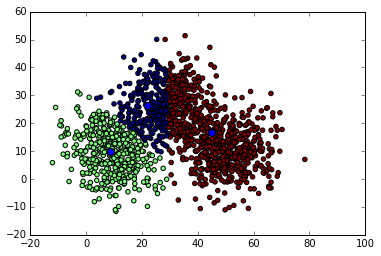

In [19]:
## By symmetry of the problem, sub-clustering the other one of the original clusters
## results in (roughly) the same results, as a comparison of the scatter plot with the one
## above indicates.

plt.figure()
plt.scatter(data_[:, 0], data_[:, 1], c=[2]*len(dataD) + kmeans2_E2.labels_.tolist())
plt.scatter(kmeans2.cluster_centers_[0, 0], kmeans2.cluster_centers_[0, 1], c='b', s=50.0)
plt.scatter(kmeans2_E2.cluster_centers_[:, 0], kmeans2_E2.cluster_centers_[:, 1], c='b', s=50.0)
plt.show()

## K-Means with reduced variance

When we created the fake data above, we introduced a lot of variance in the random points drawn each of the equidistant points A, B and C. We can also investigate the situation where this variance is low.

In [20]:
# Add some gaussian noise around each of these points,
# associate points drawn around a single point into a single cluster

num_points = 500
stdev = 2.0  # significantly reduced variance this time

# points drawn around 1st point: cluster 'A'
clusterA_x = [xA] + list(np.random.normal(loc=xA, scale=stdev, size=num_points-1))
clusterA_y = [yA] + list(np.random.normal(loc=yA, scale=stdev, size=num_points-1))
# points drawn around 2nd point: cluster 'B'
clusterB_x = [xB] + list(np.random.normal(loc=xB, scale=stdev, size=num_points-1))
clusterB_y = [yB] + list(np.random.normal(loc=yB, scale=stdev, size=num_points-1))
# points drawn around 3rd point: cluster 'C'
clusterC_x = [xC] + list(np.random.normal(loc=xC, scale=stdev, size=num_points-1))
clusterC_y = [yC] + list(np.random.normal(loc=yC, scale=stdev, size=num_points-1))

# gather all the datapoints
x = clusterA_x + clusterB_x + clusterC_x
y = clusterA_y + clusterB_y + clusterC_y
data = zip(x, y)

# Check for a very edgy edge case where a random point could be generated more than once!
if len(data) != len(set(data)):
    raise
    
# Create labels for the clusters
d_original_labels = {z: 'A' for z in data[:num_points]}
d_original_labels.update({z: 'B' for z in data[num_points: 2*num_points]})
d_original_labels.update({z: 'C' for z in data[2*num_points: 3*num_points]})

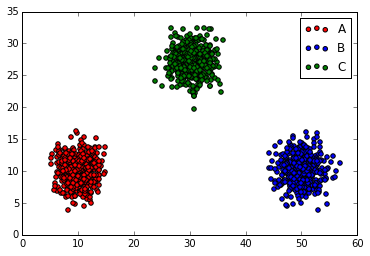

In [21]:
# Plot the clusters
plt.figure()
plt.scatter(x[:num_points], y[:num_points], label='A', c='red')
plt.scatter(x[num_points: 2*num_points], y[num_points: 2*num_points], label='B', c='blue')
plt.scatter(x[2*num_points:], y[2*num_points:], label='C', c='green')
plt.legend(loc='upper right')
plt.show()

The clusters are now well-separated from each other.

#### K-Means with 3 clusters

Repeating the same logic, but with this new data with reduced variance around the original points, we find that K-Means with 3 clusters unsurprisingly does pretty well.

In [22]:
kmeans3 = KMeans(n_clusters=3).fit(data)

d_label_3clusters = {'A': kmeans3.labels_[0], 'B': kmeans3.labels_[500], 'C': kmeans3.labels_[1000]}

original_labels = [d_label_3clusters[d_original_labels[i]] for i in data]

print "Accuracy: ", \
    len([_ for i, xx in enumerate(original_labels) if xx == kmeans3.labels_[i]])/float(len(original_labels))

Accuracy:  1.0


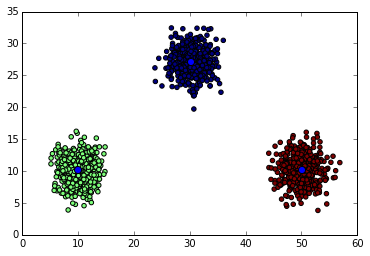

In [23]:
plt.figure()
plt.scatter(x, y, c=kmeans3.labels_)
plt.scatter(kmeans3.cluster_centers_[:, 0], kmeans3.cluster_centers_[:, 1], c='b', s=50.0)
plt.show()

The accuracy is a perfect 1.0 this time, and in fact, the learned cluster centers match the original equidistant points reasonably well.

In [24]:
kmeans3.cluster_centers_

array([[ 30.26781525,  27.15100764],
       [ 10.02386909,  10.08718154],
       [ 50.02253436,  10.1064175 ]])

In [25]:
print np.allclose(tuple(kmeans3.cluster_centers_[1]), (xA, yA), 1e-0)
print np.allclose(tuple(kmeans3.cluster_centers_[2]), (xB, yB), 1e-0)
print np.allclose(tuple(kmeans3.cluster_centers_[0]), (xC, yC), 1e-0)

True
True
True


#### K-Means sub-clustering

Next, we repeat the logic we used earlier of sequentially performing K-Means clustering with 2 clusters until we end up with a total of 3 clusters.

In [26]:
kmeans2 = KMeans(n_clusters=2).fit(data)

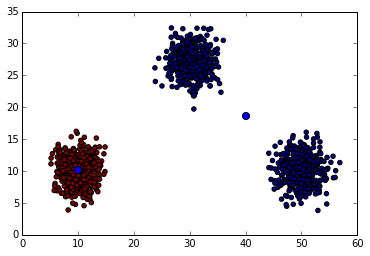

In [27]:
plt.figure()
plt.scatter(x, y, c=kmeans2.labels_)
plt.scatter(kmeans2.cluster_centers_[:, 0], kmeans2.cluster_centers_[:, 1], c='b', s=50.0)
plt.show()

This time, the first round of K-Means with 2 clusters did not evenly divide out the data. In fact, we seem to have learned the bottom-left cluster really well, but are forced to assimilate the other two group of datapoints into the same cluster.

The original symmetry of the problem is somewhat broken because of the low variance in this case, and we must now be judicious about our choice of cluster to further sub-cluster. The most obvious choice is to sub-cluster the one whose center is the blue dot on the right-hand side of the plot above.

In [28]:
# fetch the label of either (xB, yB) or (xC, yC);
# this is the cluster we want to further sub-cluster

label_to_subclust = kmeans2.predict([(xB, yB)])[0]
print label_to_subclust

0


In [29]:
# First partition the 2 previously identified clusters
dataD = [x for i, x in enumerate(data) if kmeans2.labels_[i] == label_to_subclust]
dataE = [x for i, x in enumerate(data) if kmeans2.labels_[i] == (label_to_subclust + 1)%2]

# Perform sub-clustering on both clusters D and E (but pick one of them below)
kmeans2_D2 = KMeans(n_clusters=2).fit(dataD)
kmeans2_E2 = KMeans(n_clusters=2).fit(dataE)

In [30]:
data_ = np.array(dataD + dataE)

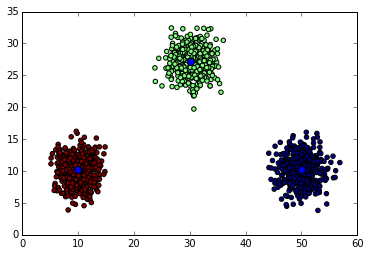

In [31]:
plt.figure()
plt.scatter(data_[:, 0], data_[:, 1], c=kmeans2_D2.labels_.tolist() + [2]*len(dataE))
plt.scatter(kmeans2_D2.cluster_centers_[:, 0], kmeans2_D2.cluster_centers_[:, 1], c='b', s=50.0)
plt.scatter(kmeans2.cluster_centers_[(label_to_subclust + 1)%2, 0], kmeans2.cluster_centers_[(label_to_subclust + 1)%2, 1], c='b', s=50.0)
plt.show()

Visually, we can see that the sub-clustering approach has worked well in this case. In fact, as we can see below, the accuracy is again a perfect 1.0. So in the case where the random points drawn around the equidistant points had a low variance, our sub-clustering approach with 2 clusters each time worked just as well as regular K-Means with 3 clusters.

In [32]:
# all predictions of this scheme in the order of
# (all data points from D) + (all data points from E)

preds = np.array(kmeans2_D2.predict(data_[:len(dataD)]).tolist() + \
                         (kmeans2.predict(data_[len(dataD):]) + 1).tolist())

d_tmp_labels = {}

# To our original cluster 'A', we can assign the predicted label of (xA, yA)
for i, x in enumerate(data_):
    if np.allclose(x, (xA, yA)):
        print preds[i]
        d_tmp_labels['A'] = preds[i]
        break
        
# To our original cluster 'B', we can assign the predicted label of (xB, yB)
for i, x in enumerate(data_):
    if np.allclose(x, (xB, yB)):
        print preds[i]
        d_tmp_labels['B'] = preds[i]
        break
        
# To the remaining cluser 'C', we can assign the remaining predicted label
if len(set(preds) - set(d_tmp_labels.values())) != 1:
    raise
    
d_tmp_labels['C'] = list(set(preds) - set(d_tmp_labels.values()))[0]

2
0


In [33]:
original_labels_v2 = [d_tmp_labels[d_original_labels[tuple(i)]] for i in data_]

In [34]:
print "Accuracy: ", \
    len([_ for i, x in enumerate(original_labels_v2) if x == preds[i]])/float(len(original_labels_v2))

Accuracy:  1.0
